<a href="https://colab.research.google.com/github/ricardoboh/zsu/blob/main/correlation_and_cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import sklearn
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import scipy.cluster.hierarchy as alternative_clustering
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Function for creating the correlation matrix of specific attributes

In [2]:
def plot_custom_heatmap(df, columns_list, title, path):
    if 'G3' not in columns_list:
        columns_list.append('G3')

    valid_cols = [col for col in columns_list if col in df.columns]
    subset_df = df[valid_cols]

    plt.figure(figsize=(10, 8))
    corr = subset_df.corr()

    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",
                linewidths=0.5, vmin=-1, vmax=1)

    plt.title(title, fontsize=14)
    #plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

## Function for creating the comparation correlation matrices

In [3]:
def plot_comparison_heatmaps(df_all, df_finished, df_kicked, columns_list, category_name):
    if 'G3' not in columns_list:
        columns_list.append('G3')

    fig, axes = plt.subplots(1, 3, figsize=(26, 8))

    fig.suptitle(f'Comparation of Correlation: {category_name}', fontsize=24, y=1.00)

    datasets = [
        (df_all, "All Students"),
        (df_finished, "Students who finished"),
        (df_kicked, "Students who was kicked")
    ]

    for i, (data, title) in enumerate(datasets):
        valid_cols = [col for col in columns_list if col in data.columns]
        subset_correlation = data[valid_cols].corr()

        sns.heatmap(subset_correlation, annot=True, cmap='coolwarm', fmt=".2f",
                    linewidths=0.5, vmin=-1, vmax=1, ax=axes[i], cbar=False,
                    annot_kws={"size": 11})

        axes[i].set_title(title, fontsize=18, pad=15)

        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
        if i == 0:
            axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0, fontsize=12)

    plt.subplots_adjust(wspace=0.5)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
    fig.colorbar(axes[0].collections[0], cax=cbar_ax)

    #filename = f"Comparison_{category_name.replace(' ', '_')}.png"
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Math student analysis

In [4]:
df_mat = pd.read_csv('student-mat.csv')

In [5]:
df_mat.shape

(395, 33)

We have 395 rows and 33 columns, which means we will have to get rid of some columns so that the Sihouette score with K-Means won't be too low.

In [6]:
df_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


When we first look at the data, we see that not all the columns are integers.
We can also notice that if we are only focusing on what influences students to do better or worse, we need to look at the last column G3, which is the score on the last test.

In [7]:
df_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

From this report we can see:

**16x typ integer**

**17x typ object**

In [8]:
df_mat.isnull().sum()

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


This table tells us that the dataset has no null values! So we don't need to edit any data.

In [9]:
df_mat.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,395,2,GP,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,395,2,F,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,395.0,NaN,NaN,NaN,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0
address,395,2,U,307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,395,2,GT3,281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,395,2,T,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,395.0,NaN,NaN,NaN,2.749367,1.094735,0.0,2.0,3.0,4.0,4.0
Fedu,395.0,NaN,NaN,NaN,2.521519,1.088201,0.0,2.0,2.0,3.0,4.0
Mjob,395,5,other,141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,395,5,other,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From this list:

school -> most of GP (Probable Cluster for students who do not go to GP)

sex -> balanced numbers of genders

age -> Overall balanced, no outliers

address -> 3/4 of data is from Urban area (Probable Cluster for Rural address)

famsize -> smaller 3/4 GT3 (Probable Clusters for other values)

Pstatus -> Dominance of T values ​​only 40 students different value = (Probably another Cluster)

Medu and Fedu -> balanced values

Mjob and Fjob -> balanced values ​​for both other prevails

reason -> balanced numbers on all 4 values ​​(Assumption, will not be important in correlation matrix)

guardian -> mothers prevail (Probably Cluster for students with other guardian)

traveltime -> (Assumption, will not be important in correlation matrix)

studytime -> (Large influence in correlation matrix)

failures -> (Assumption, will not be important in the correlation matrix)

schoolsup -> dominance of students who do not attend school support groups. (Probably another cluster of people who go to the support center.)

famsup -> balanced data

paid -> balanced data

activities -> balanced data

nursery -> dominated by yes value (Probably cluster with no value)

higher -> Massive dominance of people who want to continue their studies (Probably cluster with students who do not want to continue their studies.)

internet -> Dominance of students who have internet (Cluster with students who do not have internet)

romantic -> balanced (Assumption, will not affect G3)

famrel -> medium to high values

freetime -> rather medium values

goout -> again rather medium values

Dalc -> rather lower values ​​(Assumption, will be important in the correlation matrix, link to failures, freetime, goout and Walc)

Walc -> higher values ​​than Dalc, same assumption as Dalc

health -> rather higher values

absences -> Outlier 75 absences, we have to check

G1 -> no one scored 0 on the first test

G2 -> group of people who scored 0 (will be from this Cluster group)

G3 -> group of people who scored 0 (will be from this Cluster group)

We take a look on students who scored 0 on the second test.

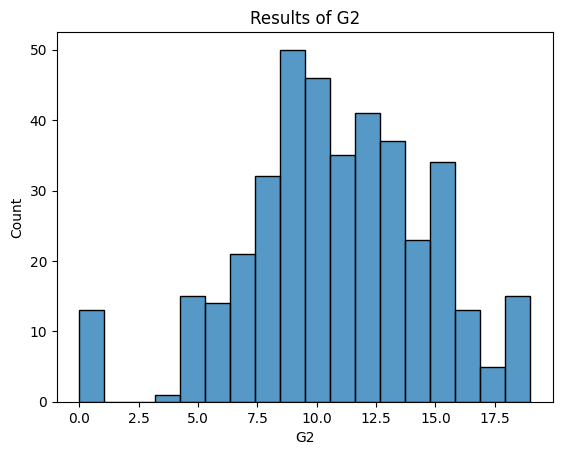

In [10]:
sns.histplot(x=df_mat['G2'])
plt.title('Results of G2')
plt.show()

From the graph we see that there are 12 outliers who scored 0 on the second graph.

And now on the students who scored 0 on the third graph.

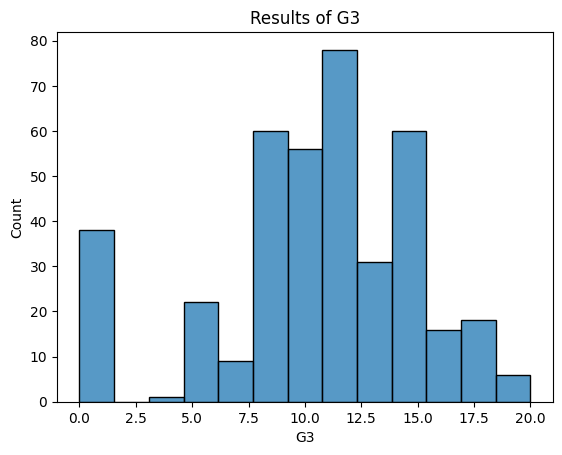

In [11]:
sns.histplot(x=df_mat['G3'])
plt.title('Results of G3')
plt.show()

Here are outliers ~40 of students.

We will try to see if those who failed in G2 were also successful in G3, or if someone improve their result.

In [12]:
intersection = pd.crosstab(df_mat['G2'] == 0, df_mat['G3'] == 0, rownames=['G2 is Zero'], colnames=['G3 is Zero'])
intersection

G3 is Zero,False,True
G2 is Zero,,
False,357,25
True,0,13


From this crosstab we can see that 357 students scored at least one point on each of the tests.

25 students scored at least some points on the second test, but scored 0 on the third test.

And 13 students scored 0 points on both tests.

And the last value 0 tells us that no student who scored 0 on the second test had any points on the third test.

Verification:
357 + (13+25) = 395 which is the total number of our students.

We take a look on absences of students and we will get rid of students with the highest absence.

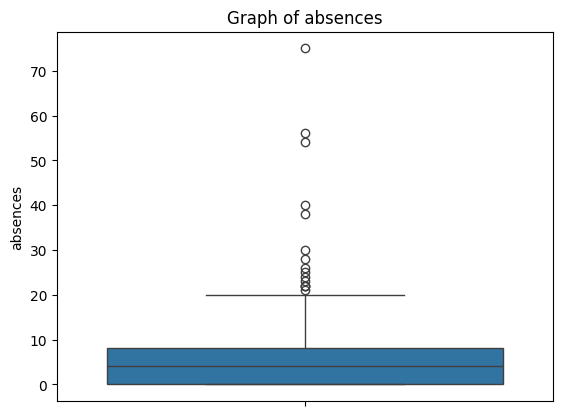

In [13]:
sns.boxplot(y=df_mat["absences"])
plt.title("Graph of absences")
plt.show()

From the graph, we can see that the outliers start after 30 absences. Therefore, we can remove them from the overall dataset.


In [14]:
df_preprocessed = df_mat[df_mat['absences'] < 30].copy()

We marked also if the student finish the course or not.

In [15]:
df_preprocessed['scoredNull'] = (df_preprocessed["G3"] == 0).astype(int)

We take a look on the column failures, if the column scoredNull is not redundant.

In [16]:
intersection_failed = pd.crosstab(df_preprocessed['scoredNull'] == 1, df_preprocessed['failures'] == 0, rownames=['scores zero in G3'], colnames=['student have no failures'])
intersection_failed

student have no failures,False,True
scores zero in G3,,
False,61,290
True,20,18


This table tell us that the 0 points does not mean the failure because there are 20 of students that scores zero, but still were not kicked out of the course.

Also this tell us that the student can score too little points to pass the exam 61 of students scored some points, but still failed.

Now when we have studied the data we move to preprocessing and preprocess the object columns into int columns.

In [17]:
object_columns = df_preprocessed.select_dtypes(include=['object']).columns
for column in object_columns:
  print(f"Column name: {column}")
  print(f"Values: {df_preprocessed[column].unique()}\n")

Column name: school
Values: ['GP' 'MS']

Column name: sex
Values: ['F' 'M']

Column name: address
Values: ['U' 'R']

Column name: famsize
Values: ['GT3' 'LE3']

Column name: Pstatus
Values: ['A' 'T']

Column name: Mjob
Values: ['at_home' 'health' 'other' 'services' 'teacher']

Column name: Fjob
Values: ['teacher' 'other' 'services' 'health' 'at_home']

Column name: reason
Values: ['course' 'other' 'home' 'reputation']

Column name: guardian
Values: ['mother' 'father' 'other']

Column name: schoolsup
Values: ['yes' 'no']

Column name: famsup
Values: ['no' 'yes']

Column name: paid
Values: ['no' 'yes']

Column name: activities
Values: ['no' 'yes']

Column name: nursery
Values: ['yes' 'no']

Column name: higher
Values: ['yes' 'no']

Column name: internet
Values: ['no' 'yes']

Column name: romantic
Values: ['no' 'yes']



Based on this we see that there are some binary columns, so we can transfer them to 0 and 1

The ones that are not binary we change them with the one hot encoding

In [18]:
binary_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus',
                'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'higher', 'internet', 'romantic']

one_hot_cols = ['Mjob', 'Fjob', 'reason', 'guardian']

In [19]:
labelEnc = LabelEncoder()
for column in binary_cols:
  df_preprocessed[column] = labelEnc.fit_transform(df_preprocessed[column])

df_preprocessed = pd.get_dummies(df_preprocessed, columns=one_hot_cols, drop_first=True).astype(int)

In [20]:
df_preprocessed.shape
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 0 to 394
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   school             389 non-null    int64
 1   sex                389 non-null    int64
 2   age                389 non-null    int64
 3   address            389 non-null    int64
 4   famsize            389 non-null    int64
 5   Pstatus            389 non-null    int64
 6   Medu               389 non-null    int64
 7   Fedu               389 non-null    int64
 8   traveltime         389 non-null    int64
 9   studytime          389 non-null    int64
 10  failures           389 non-null    int64
 11  schoolsup          389 non-null    int64
 12  famsup             389 non-null    int64
 13  paid               389 non-null    int64
 14  activities         389 non-null    int64
 15  nursery            389 non-null    int64
 16  higher             389 non-null    int64
 17  internet           38

We have all values as integers, so now we can move to the relationships between attributes.

First what I am interesting about are the students that scored 0 in the G3, but still had no failures. What happend or how it is even possible?

In [21]:
df_preprocessed['focused_group'] = ((df_preprocessed['failures'] == 0) & (df_preprocessed['scoredNull'] == 1)).astype(int)

comparison = df_preprocessed.groupby('focused_group')[['Walc', 'Dalc', 'goout', 'studytime', 'freetime', 'absences', 'health', 'famrel', 'age', 'paid', 'famsize']].mean()
comparison.T

focused_group,0,1
Walc,2.326146,1.555556
Dalc,1.493261,1.222222
goout,3.099730,3.388889
studytime,2.024259,2.333333
freetime,3.250674,3.111111
absences,5.288410,0.000000
health,3.560647,3.333333
famrel,3.938005,4.000000
age,16.671159,16.888889
paid,0.460916,0.388889


If we compare the means of the all students and our specific group, the results are impresive.

These students have no absences, so the reason they score 0 is not connected with absences.
Also they look like a great students, less Walc and Dalc, more studytime. So what is behind their bad score?

In [22]:
df_noFail_scoredZero = df_preprocessed[(df_preprocessed["scoredNull"] == 1)].copy()
df_noFail_scoredZero = df_noFail_scoredZero[df_noFail_scoredZero["failures"] == 0]
df_noFail_scoredZero.shape

(18, 44)

In [23]:
df_noFail_scoredZero[['G1', 'G2', 'G3', 'Dalc', 'Walc', 'goout']]

,G1,G2,G3,Dalc,Walc,goout
131,8,0,0,1,2,3
134,9,0,0,1,1,3
135,11,0,0,1,1,3
136,10,0,0,2,4,5
140,7,9,0,1,1,2
148,7,6,0,2,1,2
168,6,7,0,1,1,5
242,6,0,0,1,1,5
244,7,0,0,1,1,4
259,10,9,0,1,1,1


For our surprise the ones that scored 0 on G3 also scored 0 on G2, but not all of them.

In [24]:
df_Fail_scoredZero = df_preprocessed[(df_preprocessed["scoredNull"] == 1)].copy()
df_Fail_scoredZero = df_Fail_scoredZero[df_Fail_scoredZero["failures"] != 0]
df_Fail_scoredZero.shape

(20, 44)

In [25]:
df_Fail_scoredZero[['G1', 'G2', 'G3', 'Dalc', 'Walc', 'goout', 'absences', 'failures']]

,G1,G2,G3,Dalc,Walc,goout,absences,failures
128,7,4,0,1,2,3,0,2
130,12,0,0,2,2,2,0,2
137,4,0,0,1,1,2,0,2
144,5,0,0,1,2,5,0,3
146,6,7,0,1,1,2,0,3
150,6,5,0,2,5,5,0,3
153,5,0,0,1,1,4,0,3
160,7,6,0,2,2,2,0,2
162,7,0,0,2,4,4,0,1
170,6,5,0,2,4,5,0,2


So this is the key:
There are two main reasons for this behaviour
1. the failures are not connected to this dataset and they are global failures also from other courses
2. the group that have 0 failures and scored 0 in G3 or G2 and G3 are the students that was expeld or changed school (They did not take the test and they are not in the school for absences anymore)

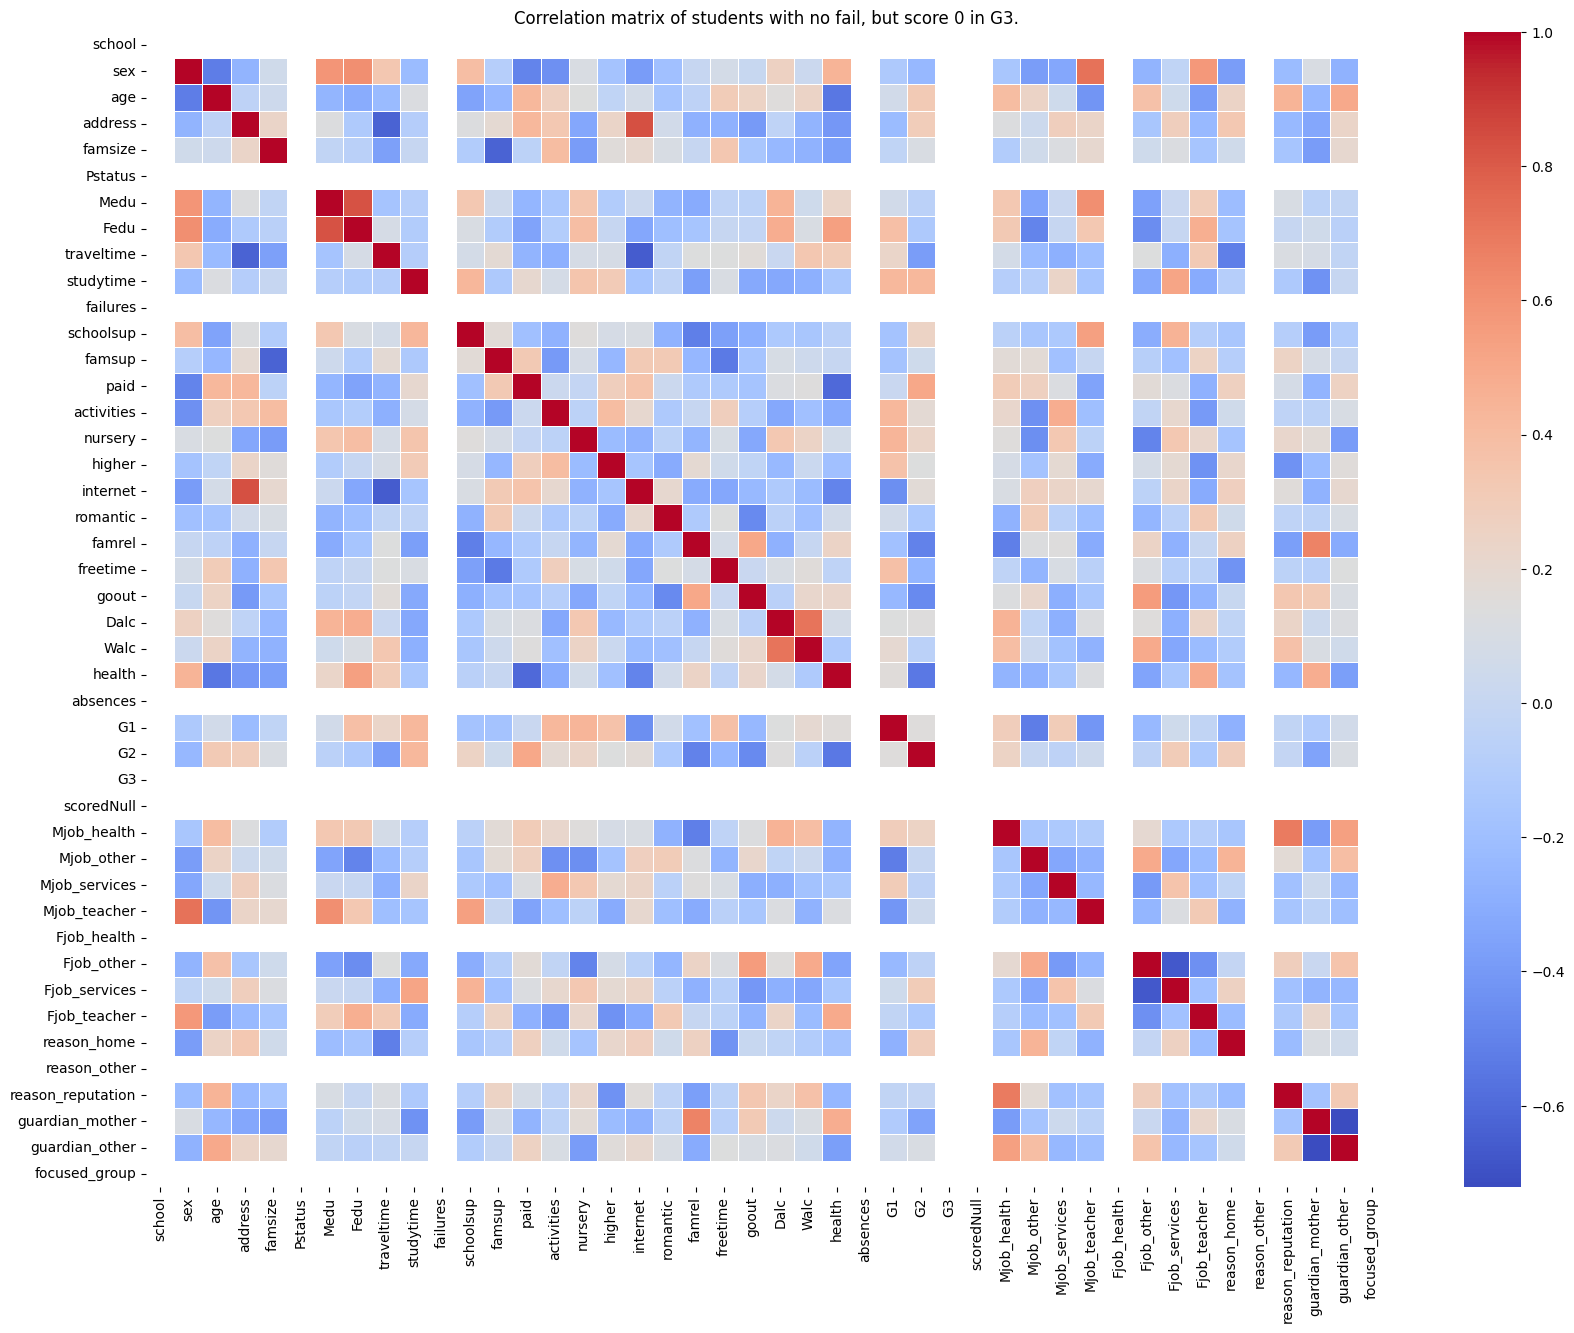

In [26]:
corr_matrix_noFail_scoredZero = df_noFail_scoredZero.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix_noFail_scoredZero, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix of students with no fail, but score 0 in G3.")
#plt.savefig("correlation_matrix_specific_group.png", dpi=300, bbox_inches='tight')
plt.show()

From this correlation matrix we can see that we have some attributes with the same value across all the students.

In [27]:
df_noFail_scoredZero[["school", "Pstatus", "absences", "Fjob_health", "reason_other"]]

,school,Pstatus,absences,Fjob_health,reason_other
131,0,1,0,0,0
134,0,1,0,0,0
135,0,1,0,0,0
136,0,1,0,0,0
140,0,1,0,0,0
148,0,1,0,0,0
168,0,1,0,0,0
242,0,1,0,0,0
244,0,1,0,0,0
259,0,1,0,0,0


We can drop columns G3, scoreNull, failures - because we know its values

We also can drop the columns
school, because we know that the value is: GP for all students

Pstatus, because every student has its parents together

No students have its mother in health sector and no student has also other reason for studying than home and reputation.

In [28]:
columns_to_pop = ["G3", "scoredNull", "failures", "school", "Pstatus", "Fjob_health", "reason_other", "absences", "focused_group"]
for col in columns_to_pop:
  df_noFail_scoredZero.pop(col)

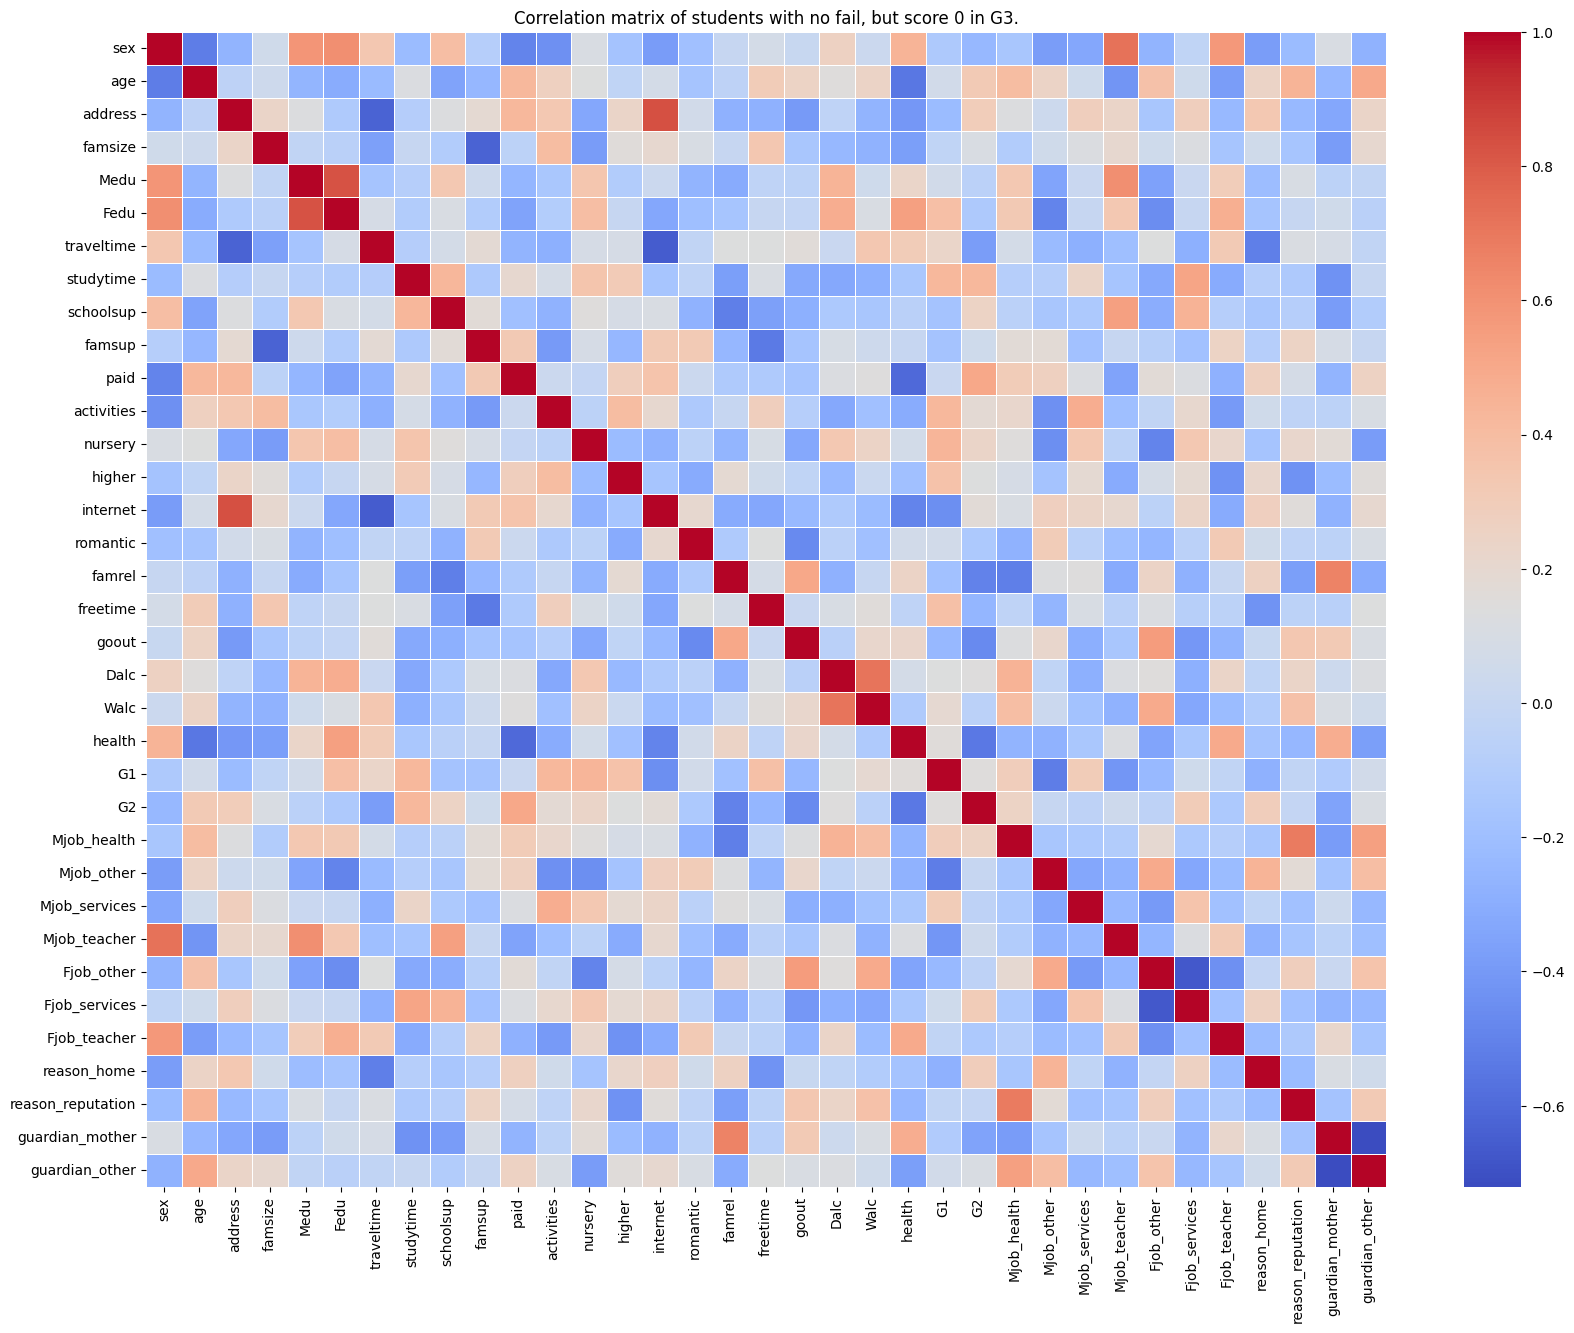

In [29]:
corr_matrix_noFail_scoredZero = df_noFail_scoredZero.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix_noFail_scoredZero, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix of students with no fail, but score 0 in G3.")
#plt.savefig("correlation_matrix_specific_group.png", dpi=300, bbox_inches='tight')
plt.show()

From this correlation matrix we can see that there is a strong possitive connection between the internet and address, so students that lives in urban area's often has access to the internet. Also from the correlation matrix is visible that the course is located in the Urban area, because the students, that lives in the rural area and do not have internet access is negative correlation.

Also the students whose mother is teacher are often male students and its mother has higher education, that makes sense. These students also going to school support center.

On the other hand students whose mother is in the health sector often goes to course because of the reputation. These students haven't its guardian mother nor father. This results in higher Daily alcohol consumption.

Students who has its guardian mother often has higher family relationships and are healthier.

Between the famsup and famsize is negative correlation as well, that means that if the family is larger, thay haven't so much time for the child.

There is also visible, that with larger age the health drops.

If the student has paid education, they have better score in G2.

If the father is in education sector, the mother is in education sector as well.

Daily alcohol consumption is also connected with the weekend alcohol consumption.

The opposites are obvious and do not have need of commenting.

So we can drop the students that are in our now analyzed group.

In [30]:
df_preprocessed = df_preprocessed[df_preprocessed["focused_group"] == 0].copy()

In [31]:
df_preprocessed.shape

(371, 44)

So now we take a look what attributes are important for us when we are analysing the G1, G2, G3 score.

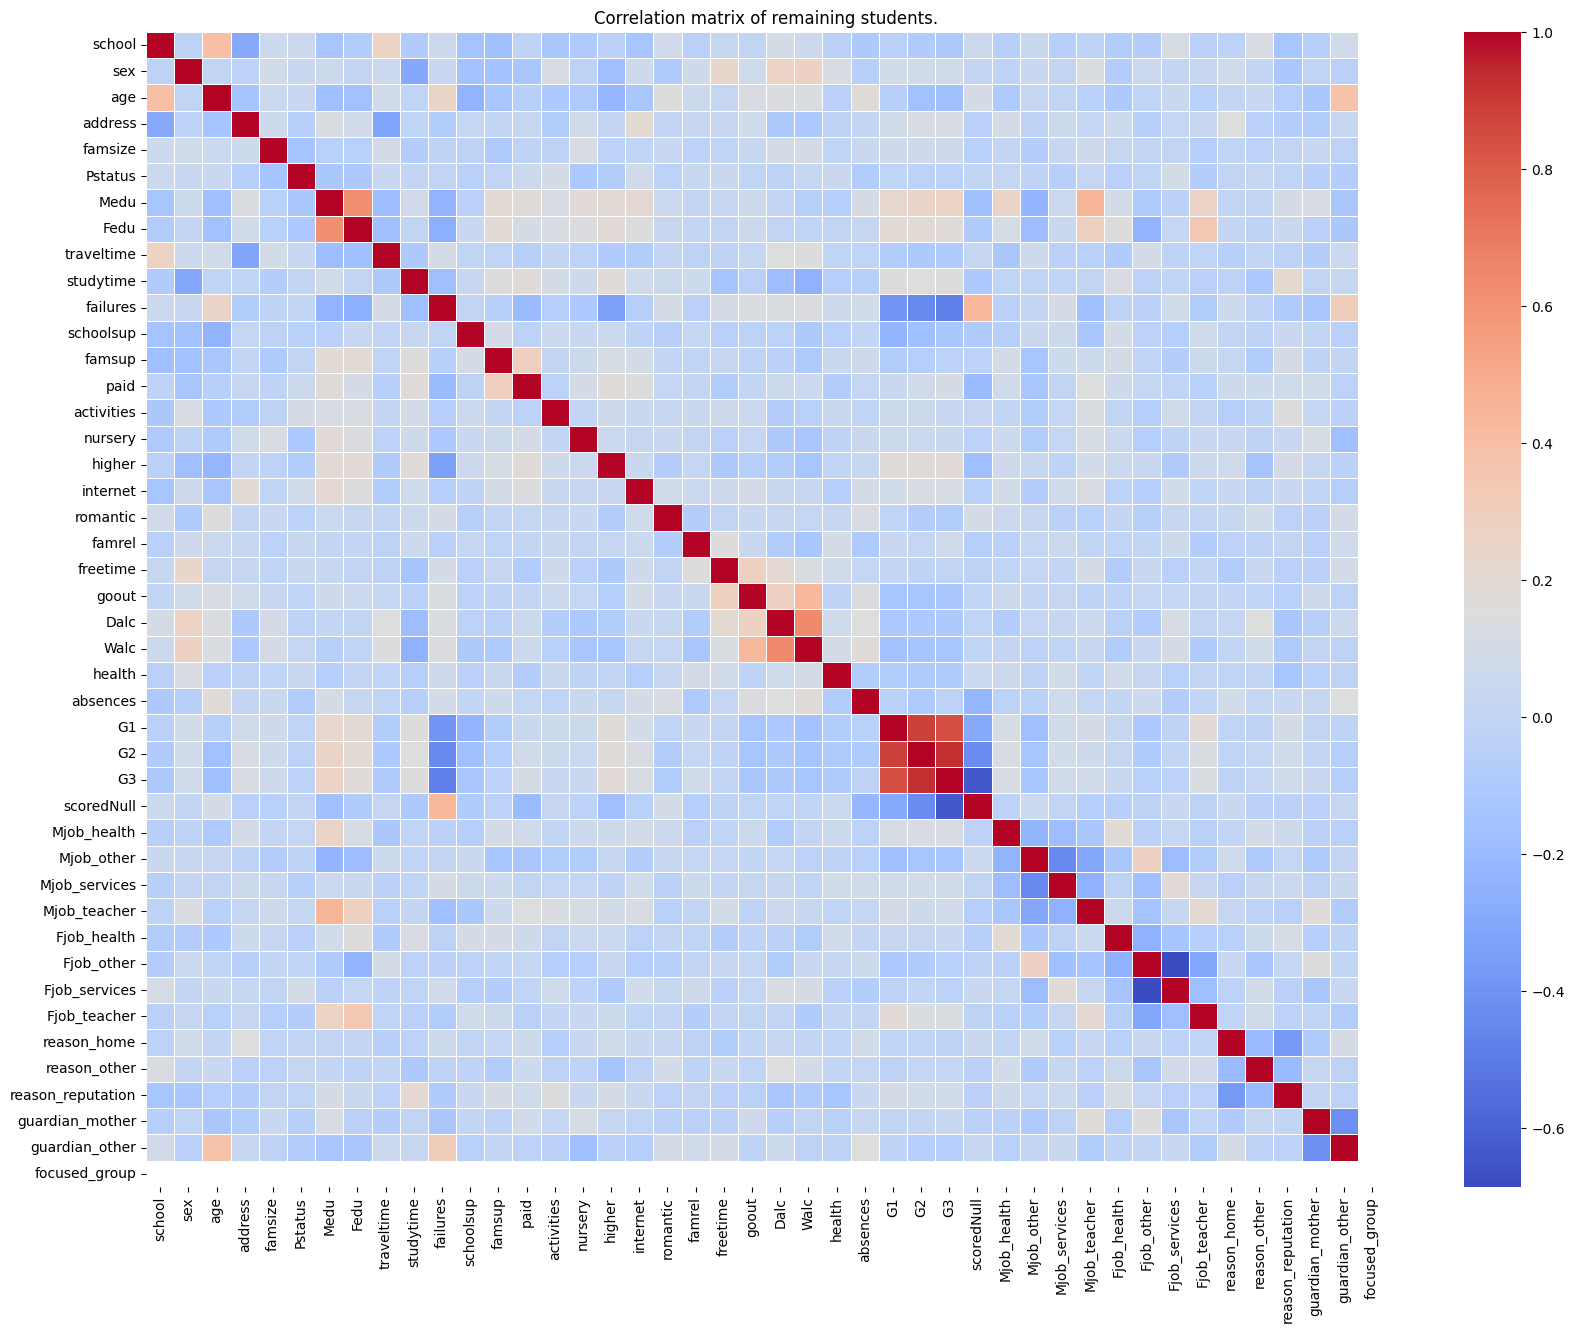

In [32]:
corr_matrix_preprocessed = df_preprocessed.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix_preprocessed, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix of remaining students.")
#plt.savefig("correlation_matrix_specific_group.png", dpi=300, bbox_inches='tight')
plt.show()

From the correlation matrix we can focus on:

failures

absences

Dalc

goout

studytime

Medu

Fedu

higher

G3



In [33]:
connected_features = ["failures", "absences", "Dalc", "goout", "studytime", "Medu", "Fedu", "higher", "G3"]

# Kmeans clustering

In [34]:
selected_df = df_preprocessed[connected_features]
sc = MinMaxScaler()
scaled = sc.fit_transform(selected_df)

distances = []
silhouette = []
cluster_range = range(2, 12)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans.fit(scaled)

    distances.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled, kmeans.labels_))

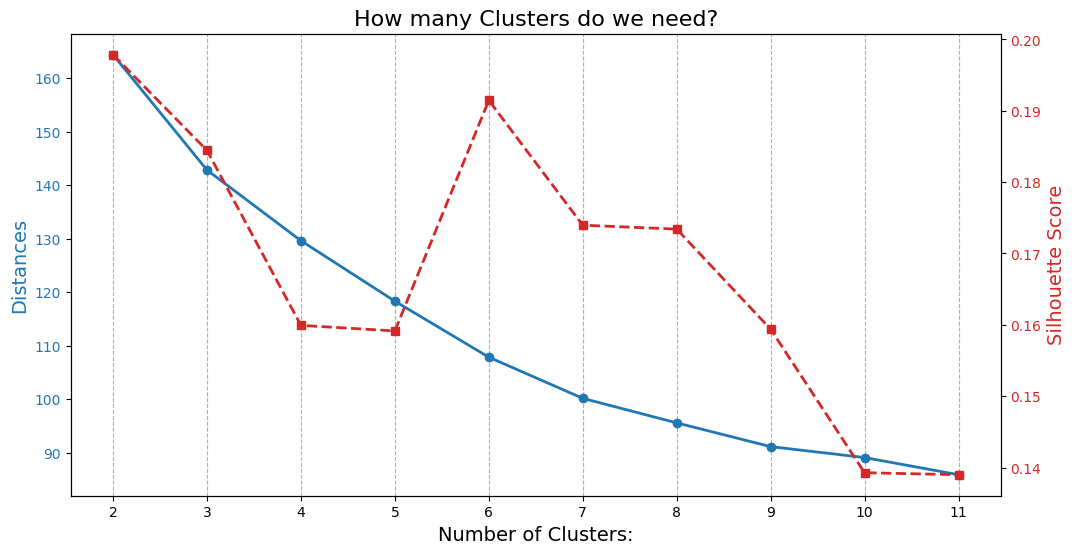

In [35]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters:', fontsize=14)
ax1.set_ylabel('Distances', color=color, fontsize=14)
ax1.plot(cluster_range, distances, marker='o', linestyle='-', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='x', linestyle='--')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=14)
ax2.plot(cluster_range, silhouette, marker='s', linestyle='--', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('How many Clusters do we need?', fontsize=16)
plt.xticks(cluster_range)

#plt.savefig('Elbow_Silhouette_Analysis_MinMaxScaler_Selected.png', dpi=300, bbox_inches='tight')
plt.show()

So the number of Clusters is 6-7 we will be counting with 6 clusters, the Silhouette score is highest there, there is no visible elbow, but in my opinion 6 clusters is the best option.

In [36]:
number_of_clusters = 6
kmeans = KMeans(n_clusters=number_of_clusters, random_state=1)

df_preprocessed['cluster_id'] = kmeans.fit_predict(scaled)
df_preprocessed['cluster_id'].value_counts().sort_index()

,count
cluster_id,
0,29
1,94
2,73
3,52
4,67
5,56


From this count result we can deduct that the cluster 0 will be some sort of specific group, the 1 cluster will probably be the average students.

Lets take a look at our data graphs and see if we were right.

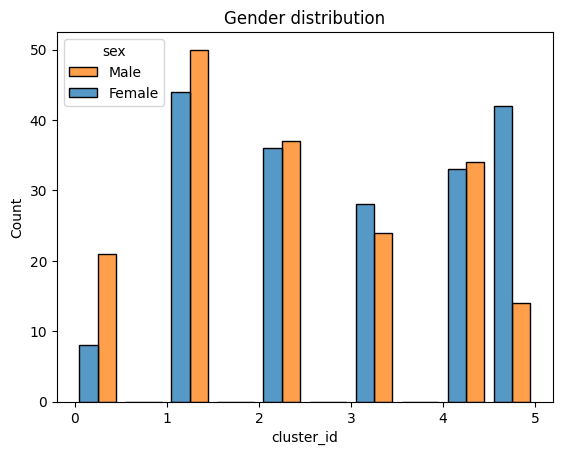

In [51]:
sns.histplot(data=df_preprocessed, x='cluster_id', hue='sex', multiple='dodge', shrink=0.8)
plt.legend(title='sex', labels=['Male', 'Female'])
plt.title('Gender distribution')
plt.show()

From this graph that is obvious that in the first (0) cluster there are males more than females.

In the cluster (5) it is all way around.

Rest of clusters are somewhat equal males and females.

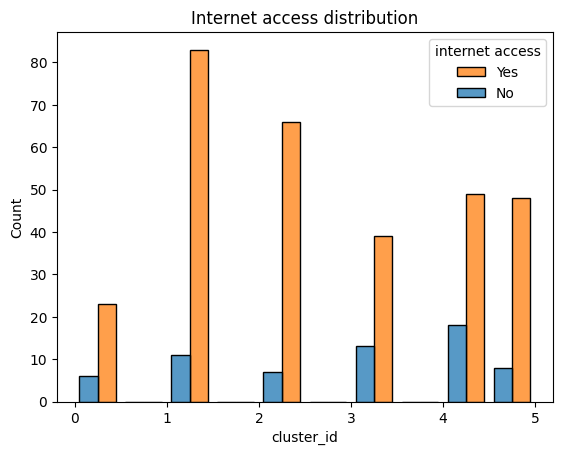

In [55]:
sns.histplot(data=df_preprocessed, x='cluster_id', hue='internet', multiple='dodge', shrink=0.8)
plt.legend(title='internet access', labels=['Yes', 'No'])
plt.title('Internet access distribution')
plt.show()

There is no cluster specifically telling that these students have no internet, but the cluster 3 and 4 is nearest to this, are these students from rural area?

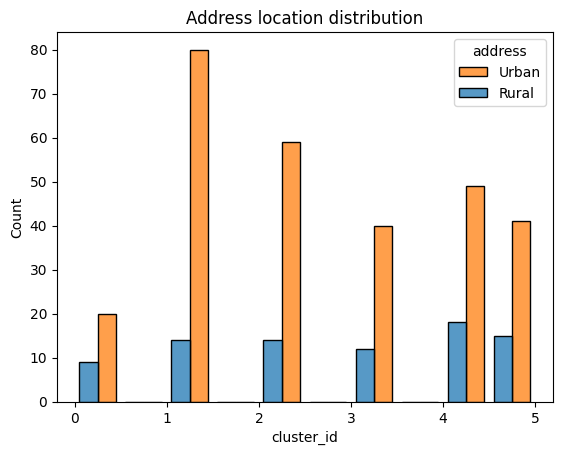

In [58]:
sns.histplot(data=df_preprocessed, x='cluster_id', hue='address', multiple='dodge', shrink=0.8)
plt.legend(title='address', labels=['Urban', 'Rural'])
plt.title('Address location distribution')
plt.show()

In [59]:
#df_preprocessed[df_preprocessed['cluster_id'] == 0]['address']

This confirms our theory, the cluster (4) !include! students that lives in the rural area and do not have access to internet. The cluster (0) also have high percent of rural students.

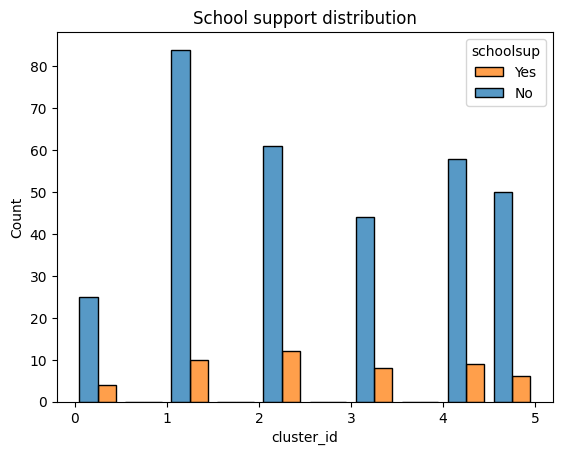

In [63]:
sns.histplot(data=df_preprocessed, x='cluster_id', hue='schoolsup', multiple='dodge', shrink=0.8)
plt.legend(title='schoolsup', labels=['Yes', 'No'])
plt.title('School support distribution')
plt.show()

From this we can see that the cluster (2) include the group that is using the school support group.

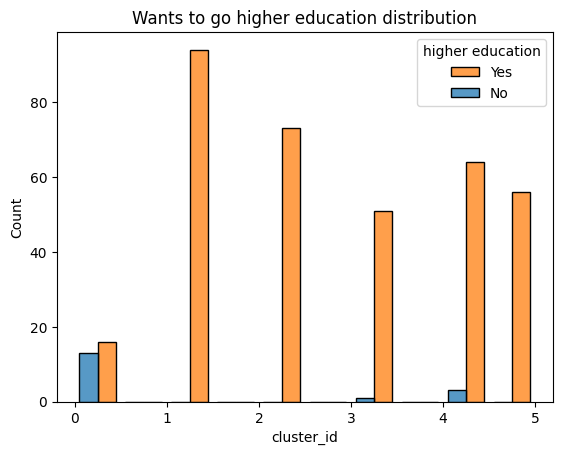

In [65]:
sns.histplot(data=df_preprocessed, x='cluster_id', hue='higher', multiple='dodge', shrink=0.8)
plt.legend(title='higher education', labels=['Yes', 'No'])
plt.title('Wants to go higher education distribution')
plt.show()

This is interesting insight that the specific group cluster (0) do not want to continue in studying. Lets take a look on the grades that have students in cluster (0)

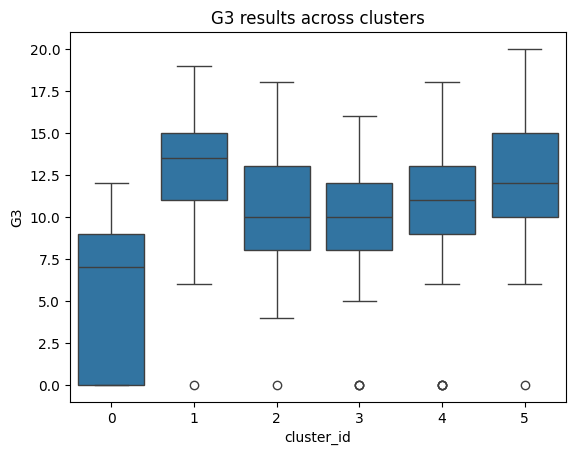

In [64]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='G3')
plt.title('G3 results across clusters')
plt.show()

And this is the great results, because now we can identify the cluster (0) are male students from rural area. They do not want to go to higher education, because their grades are not great.

cluster (2) on the other hand include the students that visits the school support center and their grades are improving.

cluster (5) are females that wants to go to higher education and their results are better than average.

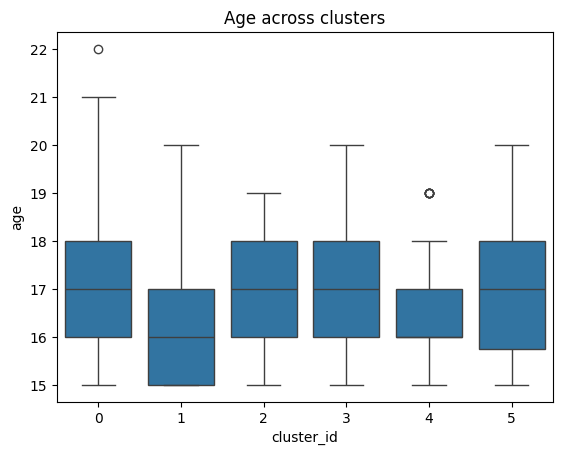

In [66]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='age')
plt.title('Age across clusters')
plt.show()

This finally encode the cluster (1) our biggest group. They are students that are the youngest. They wanna go to higher education and their results (grades) are excelent, they live primarly in Urban areas and rarely do not have access to internet.

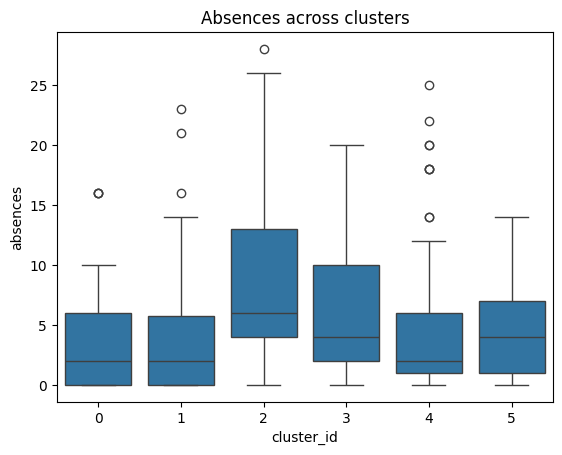

In [67]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='absences')
plt.title('Absences across clusters')
plt.show()

The cluster (2) are students with the highest absences, so the support center wasn't for no reason? Lets take a look about going out if the cluster (2) will have high results.

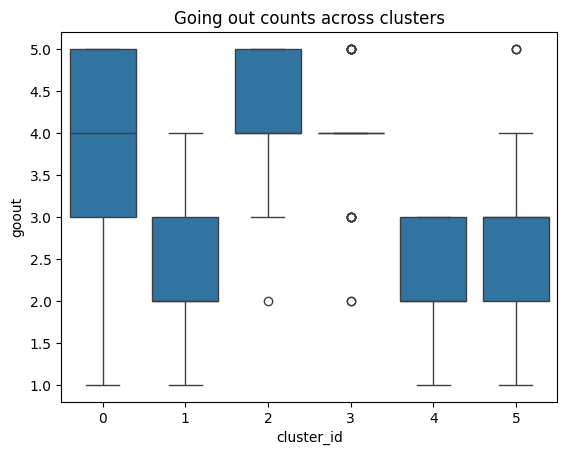

In [68]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='goout')
plt.title('Going out counts across clusters')
plt.show()

And we are right, the cluster (2) include students that are going out and do not have time for school, so they decided to go to support center and although they are going out their results are average.

Cluster (0) has also higher value of going out count, that verify the truth that the males are going out more often than females.

Lets take a look to alcohol, if they are drinking too.

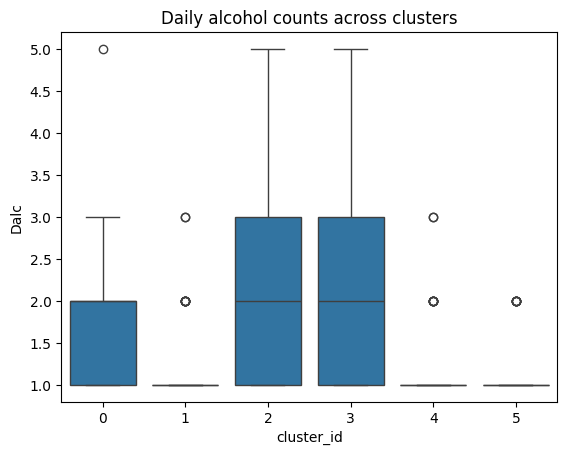

In [69]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='Dalc')
plt.title('Daily alcohol counts across clusters')
plt.show()

Our smart group clusters (1,5) do not drink alcohol also the cluster (4) is not drinking and it is because they are underage.

Hypothesis about the cluster (2) was correct.

But what is the cluster (3) it seems like the average students...

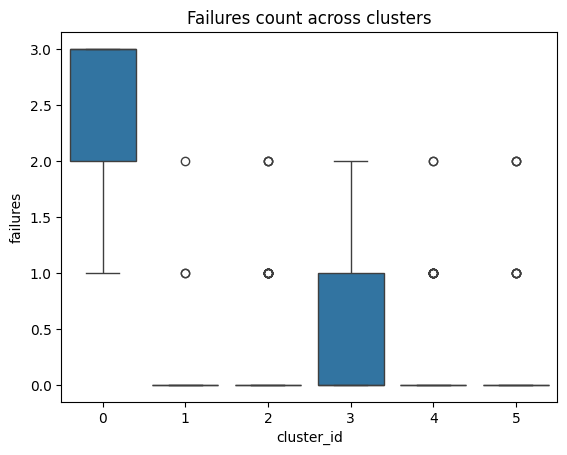

In [70]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='failures')
plt.title('Failures count across clusters')
plt.show()

This graph succesfully verify the theory that the cluster (0) has very bad results.

Cluster (3) is now in spotlight because it includes the students that fail at least once.

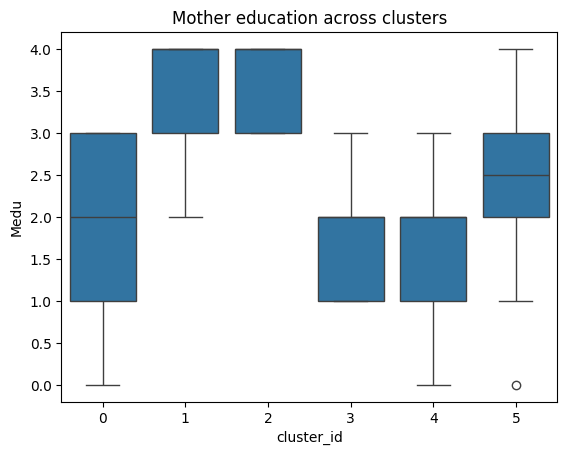

In [71]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='Medu')
plt.title('Mother education across clusters')
plt.show()

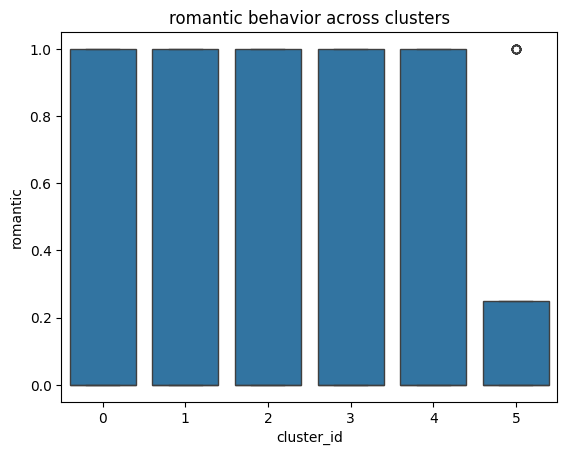

In [72]:
sns.boxplot(data=df_preprocessed, x='cluster_id', y='romantic')
plt.title('Romantic behavior across clusters')
plt.show()

Female nerd students are less romantic than the rest.


# Alternative clustering

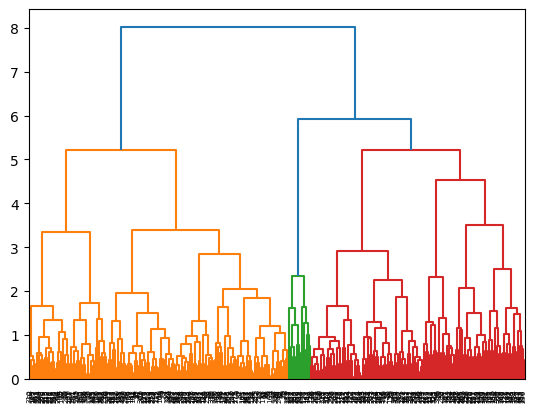

In [89]:
dendrogram_1 = alternative_clustering.dendrogram(alternative_clustering.linkage(scaled, method='ward'))
plt.show()

We split the longest vertical line in half

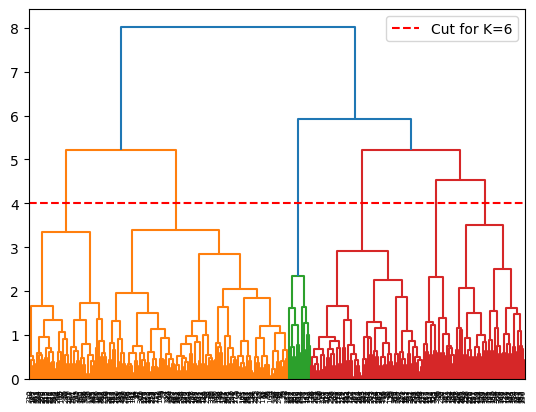

In [91]:
dendrogram_1 = alternative_clustering.dendrogram(alternative_clustering.linkage(scaled, method='ward'))

plt.axhline(y=4, color='r', linestyle='--', label='Cut')
plt.legend()
plt.show()

We can see that there are 6 clusters the same number as the Kmeans clustering.

In [92]:
kmeans_alternative = AgglomerativeClustering(n_clusters=number_of_clusters, linkage='ward', metric='euclidean')
df_preprocessed['cluster_alt_id'] = kmeans_alternative.fit_predict(scaled)
df_preprocessed['cluster_alt_id'].value_counts().sort_index()

,count
cluster_alt_id,
0,52
1,134
2,17
3,84
4,60
5,24


We see that the numbers confirm the graph. The cluster (2) is a small isolated group, some ouliers. (My theory: Those who scored 0 in G3)

cluster_alt_id   0   1   2   3   4   5
cluster_id                            
0               16   0  13   0   0   0
1                2  77   0   4  11   0
2               10  41   0   0  10  12
3               10   3   1  26   0  12
4                9   5   3  50   0   0
5                5   8   0   4  39   0


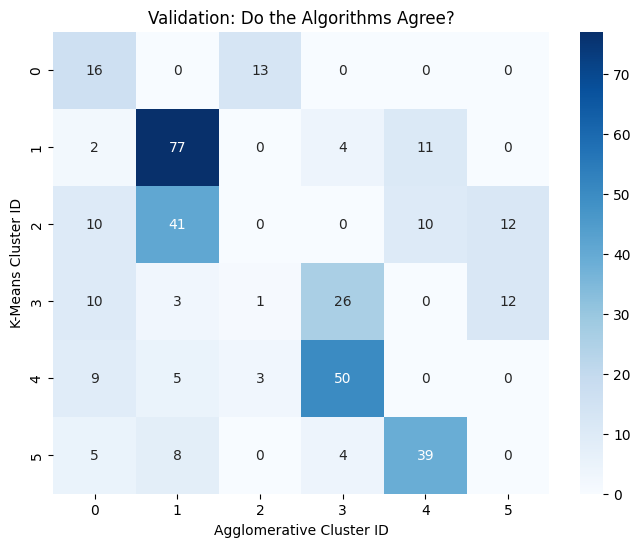

In [96]:
comparison_matrix = pd.crosstab(df_preprocessed['cluster_id'], df_preprocessed['cluster_alt_id'])

plt.figure(figsize=(8, 6))
sns.heatmap(comparison_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Comparasion of K means and Aglomerative groups')
plt.ylabel('KMeans Cluster ID')
plt.xlabel('Agglomerative Cluster ID')
plt.show()

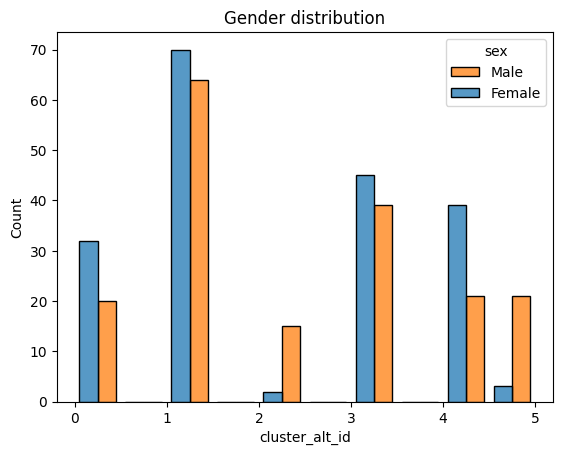

In [97]:
sns.histplot(data=df_preprocessed, x='cluster_alt_id', hue='sex', multiple='dodge', shrink=0.8)
plt.legend(title='sex', labels=['Male', 'Female'])
plt.title('Gender distribution')
plt.show()

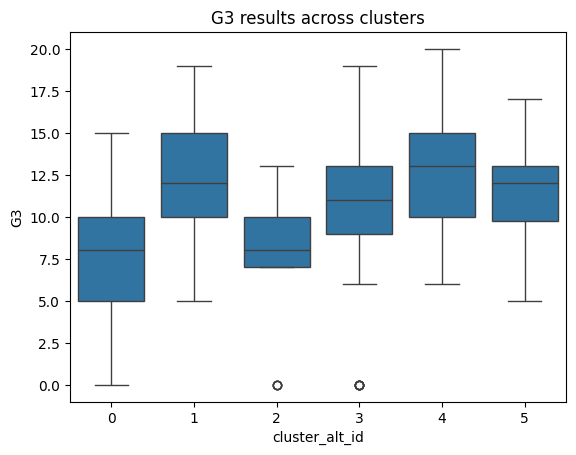

In [100]:
sns.boxplot(data=df_preprocessed, x='cluster_alt_id', y='G3')
plt.title('G3 results across clusters')
plt.show()

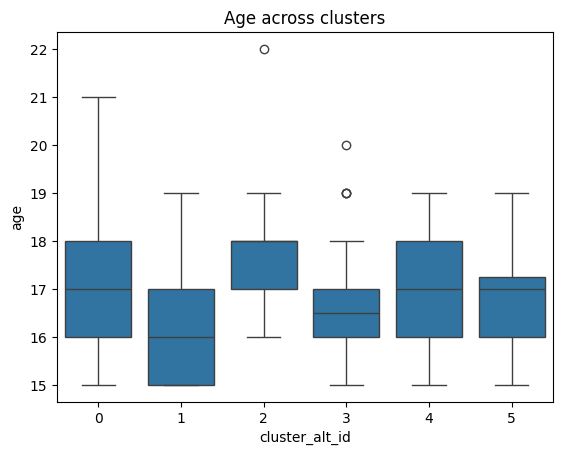

In [101]:
sns.boxplot(data=df_preprocessed, x='cluster_alt_id', y='age')
plt.title('Age across clusters')
plt.show()

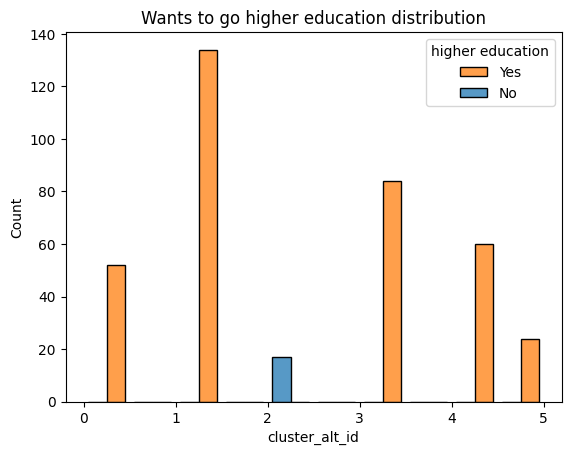

In [102]:
sns.histplot(data=df_preprocessed, x='cluster_alt_id', hue='higher', multiple='dodge', shrink=0.8)
plt.legend(title='higher education', labels=['Yes', 'No'])
plt.title('Wants to go higher education distribution')
plt.show()

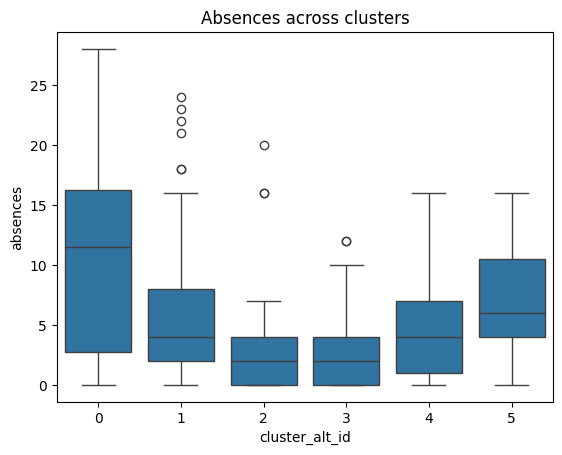

In [103]:
sns.boxplot(data=df_preprocessed, x='cluster_alt_id', y='absences')
plt.title('Absences across clusters')
plt.show()

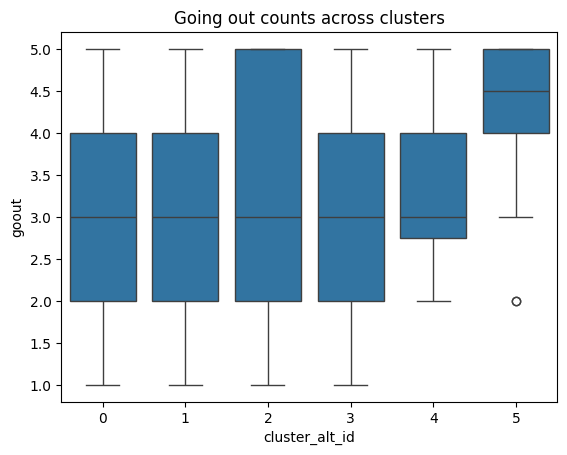

In [104]:
sns.boxplot(data=df_preprocessed, x='cluster_alt_id', y='goout')
plt.title('Going out counts across clusters')
plt.show()

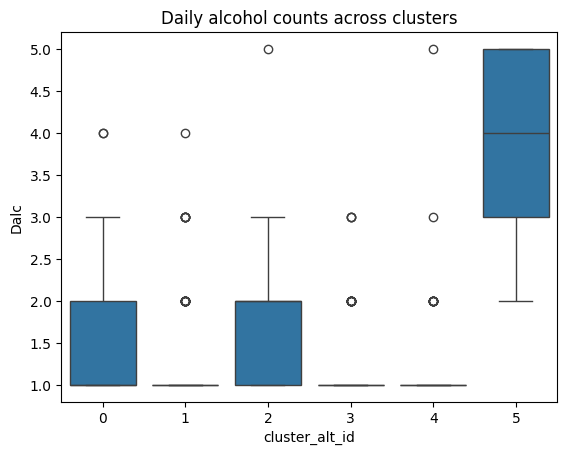

In [105]:
sns.boxplot(data=df_preprocessed, x='cluster_alt_id', y='Dalc')
plt.title('Daily alcohol counts across clusters')
plt.show()

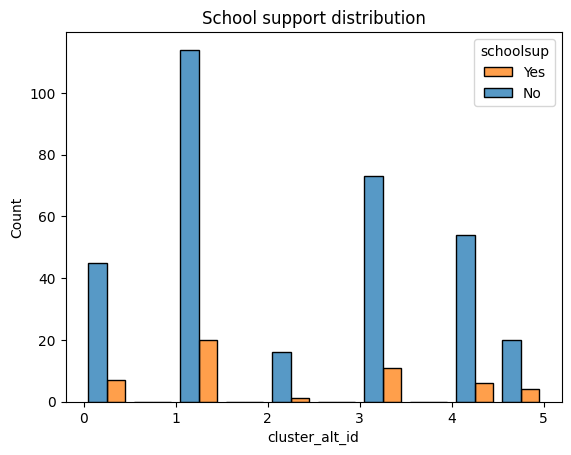

In [106]:
sns.histplot(data=df_preprocessed, x='cluster_alt_id', hue='schoolsup', multiple='dodge', shrink=0.8)
plt.legend(title='schoolsup', labels=['Yes', 'No'])
plt.title('School support distribution')
plt.show()

To finalize this report we have the young smart students in Cluster (1), We have our party group split in Cluster (0,2,5).
In Cluster (2) are just the students that do not want to go to higher education.
Cluster (4) are smart female students.


So to sumarize this report, the G3 score is highly affected by the decision if they wanna go to the higher education, by the previous score, because there are no sudden improvement or worsening of score. Also the Females and the younger students score bigger in G3.

There were some sort of "ghosts" in the dataset, which I removed and make the whole correlation analysis about them, but they have not influence on G3 score so it is not worth commenting here.

*Richard Bohunovský BOH0162 6.12.2025*